In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [3]:
# same as sklearn 
df = pd.read_csv("data/allHorizonData_cut.csv")

seq_features = [
    'r1', 'c1', 'rt1',
    'r2', 'c2', 'rt2',
    'r3', 'c3', 'rt3',
    'r4', 'c4', 'rt4'
]
static_features = ['gameLength', 'uc']

target = 'c5'

X_seq = df[seq_features]
X_static = df[static_features]
y = df[target]
y = y-1 # binary CE only takes in 0, 1

X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(X_seq, X_static, y, test_size=0.2, random_state=42)

# split based on original data frame
h1_mask = X_static_test['gameLength'] == 5
h6_mask = X_static_test['gameLength'] == 10
X_static_test_raw = X_static_test.copy()

scaler = StandardScaler()
X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())

--- Feature Data (X) ---
   r1  c1       rt1  r2  c2       rt2  r3  c3       rt3  r4  c4       rt4
0  66   2  1.849054  80   2  1.771619  29   1  0.562676  75   2  0.578808
1  69   2  0.967068  50   2  0.495166  51   1  0.506639  64   2  0.460037
2  31   2  0.862793  43   1  0.490816  26   2  0.924838  36   1  0.951034
3  65   1  6.272626  77   2  1.204784  52   2  0.795462  73   1  0.457327
4  70   2  0.614185  19   1  0.364167  43   2  0.306713  41   1  0.372321
   gameLength  uc
0           5   3
1          10   3
2          10   2
3          10   2
4          10   2

--- Target Data (y) ---
0    1
1    0
2    0
3    0
4    1
Name: c5, dtype: int64


In [4]:
print(X_seq_train.shape)
print(type(X_seq_train))
print(type(y_train))

(15360, 12)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


convert to tensor for pytorch

In [5]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, 4, 3)
print(X_seq_train.shape)
print(type(X_seq_train))
print(X_seq_train[0])
X_seq_test = X_seq_test.reshape(-1, 4, 3)
print(X_seq_test.shape)
print(type(X_seq_test))

(15360, 4, 3)
<class 'numpy.ndarray'>
[[-0.04839109 -1.00326052 -0.06340892]
 [ 1.97202053  0.98706284 -0.09338387]
 [ 1.12278856  1.00430615 -0.11580627]
 [ 1.3450348   1.00928792 -0.16394309]]
(3840, 4, 3)
<class 'numpy.ndarray'>


In [6]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [7]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [8]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask, dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask, dtype=torch.bool)

X_seq_test_h1 = torch.tensor(X_seq_test[h1_mask_bool], dtype=torch.float32)
X_seq_test_h6 = torch.tensor(X_seq_test[h6_mask_bool], dtype=torch.float32)

X_static_test_h1 = torch.tensor(X_static_test[h1_mask_bool], dtype=torch.float32)
X_static_test_h6 = torch.tensor(X_static_test[h6_mask_bool], dtype=torch.float32)

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]


In [9]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [10]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [11]:
class TransformerEncoderOnly(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(TransformerEncoderOnly, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.transformer = nn.TransformerEncoderLayer( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            d_model=hidden_size, 
            nhead=1, 
            dropout=0.0,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3)
        x_encoded = self.transformer(x_seq_proj) # (batch, 4, hidden_size)
        x_final = x_encoded[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output


In [12]:
class TransformerEncoderOnlyLateProjection(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(TransformerEncoderOnlyLateProjection, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.transformer = nn.TransformerEncoderLayer( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            d_model=seq_input_size, 
            nhead=1, 
            dropout=0.0,
            dim_feedforward=32,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_encoded = self.transformer(seq_x) # (batch, 4, 3)
        x_seq_proj = self.input_fc(x_encoded) # (batch, 4, hidden_size)
        x_final = x_seq_proj[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output


In [13]:
class TransformerEncoderOnlyMultihead(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(TransformerEncoderOnlyMultihead, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.transformer = nn.TransformerEncoderLayer( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            d_model=hidden_size, 
            nhead=4, 
            dropout=0.0,
            dim_feedforward=128,
            activation="relu",
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3)
        x_encoded = self.transformer(x_seq_proj) # (batch, 4, hidden_size)
        x_final = x_encoded[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4):
        super(PositionalEncoding, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model))

    def forward(self, x):
        x = x + self.pos_embedding
        return x

In [15]:
class PositionalEncodingSin(nn.Module):
    def __init__(self, d_model, max_len=4):
        super(PositionalEncodingSin, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]
        return x

In [16]:
class TransformerEncoderPositionalEncoding(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(TransformerEncoderPositionalEncoding, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(d_model=hidden_size, max_len=4)

        self.transformer = nn.TransformerEncoderLayer( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            d_model=hidden_size, 
            nhead=4, 
            dropout=0.0,
            dim_feedforward=128,
            activation="relu",
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3)
        x_encoded = self.pos_encoder(x_seq_proj)
        x_trans = self.transformer(x_encoded) # (batch, 4, hidden_size)
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

In [17]:
class SelfAttentionOnly(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(SelfAttentionOnly, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.pos_encoder = PositionalEncodingSin(d_model=hidden_size, max_len=4)

        self.attn = nn.MultiheadAttention( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            embed_dim=hidden_size, 
            num_heads=8, 
            dropout=0.0,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3) -> (batch, 4, hidden_size)
        x_encoded = self.pos_encoder(x_seq_proj)
        x_trans, _ = self.attn(x_encoded, x_encoded, x_encoded) # (batch, 4, hidden_size)
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

In [18]:
class SelfAttentionOnlyPositionEncoding(nn.Module):
    def __init__(self, seq_input_size=3, static_input_size=2, hidden_size=64, output_size=2):
        super(SelfAttentionOnlyPositionEncoding, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.pos_encoder = PositionalEncodingSin(d_model=hidden_size, max_len=4)

        self.attn = nn.MultiheadAttention( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            embed_dim=hidden_size, 
            num_heads=4, 
            dropout=0.0,
            batch_first=True
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3) -> (batch, 4, hidden_size)
        x_encoded = self.pos_encoder(x_seq_proj)
        x_trans, _ = self.attn(x_encoded, x_encoded, x_encoded) # (batch, 4, hidden_size)

        x_trans = self.mlp(x_trans)
        
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

# train / eval

In [19]:
def train(model, train_loader, criterion, optimizer, device, epoch): 
    model.train()
    train_loss = 0.0
    for seq_inputs, static_inputs, labels in train_loader:
        seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(seq_inputs, static_inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss


def test(model, test_loader, device):
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for seq_inputs, static_inputs, labels in test_loader:
            seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
            preds = model(seq_inputs, static_inputs)
            preds = preds.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

# running experiment

In [20]:
model = SelfAttentionOnlyPositionEncoding().to(device)
print(model)

SelfAttentionOnlyPositionEncoding(
  (input_fc): Linear(in_features=3, out_features=64, bias=True)
  (pos_encoder): PositionalEncodingSin()
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=66, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
epochs = 20
loss_prog = []
acc_prog = []
acc_h1_prog = []
acc_h6_prog = []

for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer, device, epoch)
    acc = test(model, test_loader, device)
    acc_h1 = test(model, test_loader_h1, device)
    acc_h6 = test(model, test_loader_h6, device)

    print(f"Epoch {epoch+1}: Loss: {loss:.4f} | overall: {acc:.4f} | H1 {acc_h1:.4f} | H6 {acc_h6:.4f}")

    loss_prog.append(loss)
    acc_prog.append(acc)
    acc_h1_prog.append(acc_h1)
    acc_h6_prog.append(acc_h6)

Epoch 1: Loss: 0.5058 | overall: 0.7956 | H1 0.8383 | H6 0.7521
Epoch 2: Loss: 0.4788 | overall: 0.7984 | H1 0.8394 | H6 0.7568
Epoch 3: Loss: 0.4742 | overall: 0.7919 | H1 0.8290 | H6 0.7542
Epoch 4: Loss: 0.4730 | overall: 0.8013 | H1 0.8471 | H6 0.7547
Epoch 5: Loss: 0.4727 | overall: 0.7943 | H1 0.8373 | H6 0.7505
Epoch 6: Loss: 0.4708 | overall: 0.7995 | H1 0.8461 | H6 0.7521
Epoch 7: Loss: 0.4699 | overall: 0.8036 | H1 0.8543 | H6 0.7521
Epoch 8: Loss: 0.4675 | overall: 0.7909 | H1 0.8337 | H6 0.7474
Epoch 9: Loss: 0.4654 | overall: 0.7990 | H1 0.8461 | H6 0.7511
Epoch 10: Loss: 0.4664 | overall: 0.7904 | H1 0.8264 | H6 0.7537
Epoch 11: Loss: 0.4651 | overall: 0.7997 | H1 0.8445 | H6 0.7542
Epoch 12: Loss: 0.4627 | overall: 0.8031 | H1 0.8492 | H6 0.7563
Epoch 13: Loss: 0.4632 | overall: 0.7966 | H1 0.8399 | H6 0.7526
Epoch 14: Loss: 0.4653 | overall: 0.8010 | H1 0.8512 | H6 0.7500
Epoch 15: Loss: 0.4624 | overall: 0.8036 | H1 0.8512 | H6 0.7553
Epoch 16: Loss: 0.4621 | overall: 

In [23]:
import matplotlib.pyplot as plt

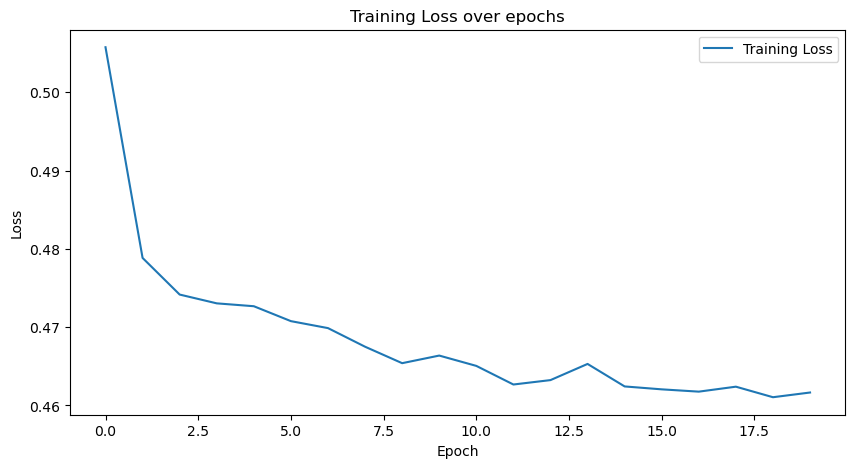

In [24]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_prog, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

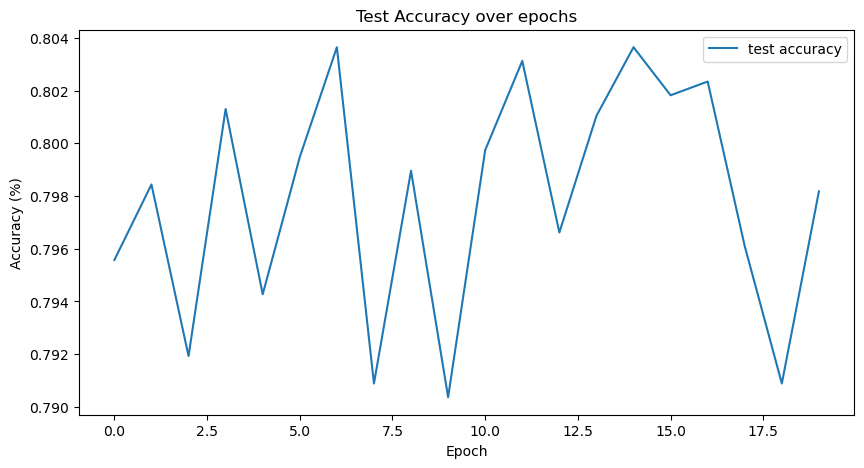

In [25]:
# plot testing accuracy
def plot_accuracy(accuracy_progress_list):
    plt.figure(figsize=(10, 5))
    for label, acc in accuracy_progress_list:
        plt.plot(range(epochs), acc, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over epochs')
    plt.legend()
    plt.show()

plot_accuracy([('test accuracy', acc_prog)])

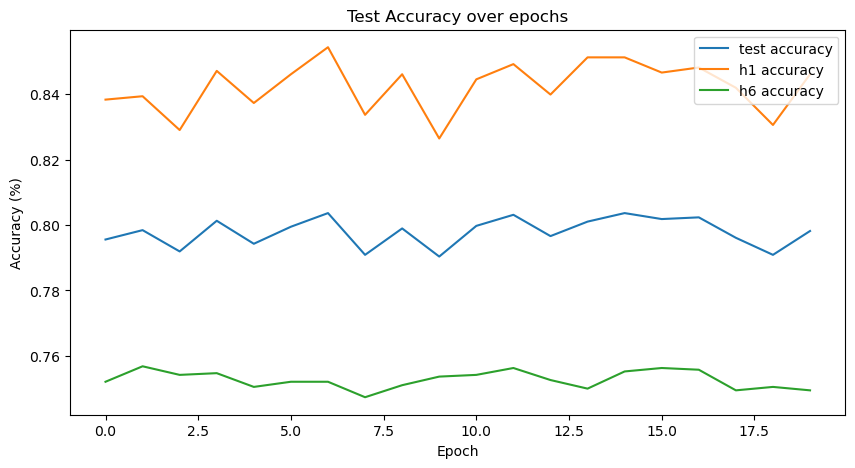

In [26]:
plot_accuracy([('test accuracy', acc_prog), ('h1 accuracy', acc_h1_prog), ('h6 accuracy', acc_h6_prog)])